# "Intro to Collaborative Filtering" plus homework

## Authors: Dmitry Ignatov
Freely avaiable for non-commercial purposes. The code examples are based on T. Segaran [Programming Collective Intelligence book. Chapter 2](http://shop.oreilly.com/product/9780596529321.do)






## Dictionary with user preferences

In [1]:
# A dictionary of movie critics and their ratings of a small
# set of movies

critics={'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5,
 'Just My Luck': 3.0, 'Superman Returns': 3.5, 'You, Me and Dupree': 2.5, 
 'The Night Listener': 3.0},
'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5, 
 'Just My Luck': 1.5, 'Superman Returns': 5.0, 'The Night Listener': 3.0, 
 'You, Me and Dupree': 3.5}, 
'Michael Phillips': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.0,
 'Superman Returns': 3.5, 'The Night Listener': 4.0},
'Claudia Puig': {'Snakes on a Plane': 3.5, 'Just My Luck': 3.0,
 'The Night Listener': 4.5, 'Superman Returns': 4.0, 
 'You, Me and Dupree': 2.5},
'Mick LaSalle': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0, 
 'Just My Luck': 2.0, 'Superman Returns': 3.0, 'The Night Listener': 3.0,
 'You, Me and Dupree': 2.0}, 
'Jack Matthews': {'Lady in the Water': 3.0, 'Snakes on a Plane': 4.0,
 'The Night Listener': 3.0, 'Superman Returns': 5.0, 'You, Me and Dupree': 3.5},
'Toby': {'Snakes on a Plane':4.5,'You, Me and Dupree':1.0,'Superman Returns':4.0}}

In [2]:
critics['Toby']

{'Snakes on a Plane': 4.5, 'Superman Returns': 4.0, 'You, Me and Dupree': 1.0}

In [3]:
critics['Lisa Rose']['Lady in the Water']


2.5

In [4]:
#Euclid distance
from math import sqrt
sqrt(pow(5-4,2)+pow(4-1,2))


3.1622776601683795

In [5]:
#distance-based simialrity 
1/(1+sqrt(pow(5-4.5,2)+pow(5-5,2)))


0.6666666666666666

In [6]:
from numpy import exp

In [7]:
exp(-0.3*sqrt(pow(5-4.5,2)+pow(5-5,2))**2)


0.9277434863285529

In [8]:
from math import sqrt
# Returns a distance-based similarity score for person1 and person2
def sim_distance(prefs,person1,person2):
# Get the list of shared_items
    si={}
    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item]=1
# if they have no ratings in common, return 0
    if len(si)==0: return 0
# Add up the squares of all the differences
    sum_of_squares=sum([pow(prefs[person1][item]-prefs[person2][item],2) for item in prefs[person1] if item in prefs[person2]])
    return 1/(1+sum_of_squares)


In [9]:
from math import sqrt
# Returns a distance-based similarity score for person1 and person2
def sim_kernel(prefs,person1,person2,alpha=0.3):
# Get the list of shared_items
    si={}
    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item]=1
# if they have no ratings in common, return 0
    if len(si)==0: return 0
# Add up the squares of all the differences and take the wieghted exponent
    sum_of_squares=sum([pow(prefs[person1][item]-prefs[person2][item],2) for item in prefs[person1] if item in prefs[person2]])
    return exp(-alpha*sum_of_squares)

In [10]:
sim_kernel(critics, 'Lisa Rose','Toby')

0.3499377491111553

In [11]:
sim_distance(critics, 'Lisa Rose','Toby')

0.2222222222222222

In [12]:
# Returns the Pearson correlation coefficient for p1 and p2
def sim_pearson(prefs,p1,p2):
 # Get the list of mutually rated items
    si={}
    for item in prefs[p1]: 
        if item in prefs[p2]: si[item]=1

     # if they are no ratings in common, return 0
    if len(si)==0: return 0

    # The number of mutually rated movies
    n=len(si)
  
    # Sums of all the preferences
    sum1=sum([prefs[p1][it] for it in si])
    sum2=sum([prefs[p2][it] for it in si])
  
    # Sums of the squares
    sum1Sq=sum([pow(prefs[p1][it],2) for it in si])
    sum2Sq=sum([pow(prefs[p2][it],2) for it in si])	
  
     # Sum of the products
    pSum=sum([prefs[p1][it]*prefs[p2][it] for it in si])
  
     # Calculate r (Pearson score)
    num=pSum-(sum1*sum2/n)
    den=sqrt((sum1Sq-pow(sum1,2)/n)*(sum2Sq-pow(sum2,2)/n))
    if den==0: return 0

    r=num/den

    return r

In [13]:
sim_pearson(critics,'Lisa Rose','Gene Seymour'), sim_distance(critics, 'Lisa Rose','Gene Seymour')



(0.39605901719066977, 0.14814814814814814)

##  Ranking of critics

In [14]:
# Returns the best matches for person from the prefs dictionary. 
# Number of results and similarity function are optional params.

def topMatches(prefs,person,n=5,similarity=sim_pearson):
    scores=[(similarity(prefs,person,other),other) for other in prefs if other!=person]
    # Descending sorting
    scores.sort( )
    scores.reverse( )
    return scores[0:n]


In [15]:
t = topMatches(critics,'Toby',n=3)


In [16]:
topMatches(critics,'Toby',n=3, similarity=sim_kernel)

[(0.5091564206075492, 'Mick LaSalle'),
 (0.4723665527410147, 'Michael Phillips'),
 (0.37719235356315695, 'Claudia Puig')]

## Movie recommendation (User-based approach)

In [17]:
# Gets recommendations for a person by using a weighted average
# of every other user's rankings

def getRecommendations(prefs,person,similarity=sim_pearson):
    totals={}
    simSums={}
    for other in prefs:
     # don't compare me to myself
        if other==person: continue
        sim=similarity(prefs,person,other)
     # ignore scores of zero or lower
        if sim<=0: continue
        for item in prefs[other]:
    # only score movies I haven't seen yet
            if item not in prefs[person] or prefs[person][item]==0:
     # Similarity * Score
                totals.setdefault(item,0)
                totals[item]+=prefs[other][item]*sim
        # Sum of similarities
                simSums.setdefault(item,0)
                simSums[item]+=sim
     # Create the normalized list
    rankings=[(total/simSums[item],item) for item,total in totals.items( )]
    # Return the sorted list
    rankings.sort( )
    rankings.reverse( )
    return rankings

In [18]:
getRecommendations(critics,'Toby')


[(3.3477895267131017, 'The Night Listener'),
 (2.8325499182641614, 'Lady in the Water'),
 (2.530980703765565, 'Just My Luck')]

In [19]:
getRecommendations(critics,'Toby', sim_kernel)

[(3.5469111370529656, 'The Night Listener'),
 (2.729687080418633, 'Lady in the Water'),
 (2.518799545549861, 'Just My Luck')]

## Items similarity

How to replace 

{'Lisa Rose': {'Lady in the Water': 2.5, 'Snakes on a Plane': 3.5},
'Gene Seymour': {'Lady in the Water': 3.0, 'Snakes on a Plane': 3.5}}

by

{'Lady in the Water':{'Lisa Rose':2.5,'Gene Seymour':3.0},
'Snakes on a Plane':{'Lisa Rose':3.5,'Gene Seymour':3.5}}?


In [20]:
def transformPrefs(prefs):
    result={}
    for person in prefs:
        for item in prefs[person]:
            result.setdefault(item,{})
    # Flip item and person
    
            result[item][person]=prefs[person][item]
    return result

In [21]:
movies=transformPrefs(critics)


In [22]:
movies

{'Just My Luck': {'Claudia Puig': 3.0,
  'Gene Seymour': 1.5,
  'Lisa Rose': 3.0,
  'Mick LaSalle': 2.0},
 'Lady in the Water': {'Gene Seymour': 3.0,
  'Jack Matthews': 3.0,
  'Lisa Rose': 2.5,
  'Michael Phillips': 2.5,
  'Mick LaSalle': 3.0},
 'Snakes on a Plane': {'Claudia Puig': 3.5,
  'Gene Seymour': 3.5,
  'Jack Matthews': 4.0,
  'Lisa Rose': 3.5,
  'Michael Phillips': 3.0,
  'Mick LaSalle': 4.0,
  'Toby': 4.5},
 'Superman Returns': {'Claudia Puig': 4.0,
  'Gene Seymour': 5.0,
  'Jack Matthews': 5.0,
  'Lisa Rose': 3.5,
  'Michael Phillips': 3.5,
  'Mick LaSalle': 3.0,
  'Toby': 4.0},
 'The Night Listener': {'Claudia Puig': 4.5,
  'Gene Seymour': 3.0,
  'Jack Matthews': 3.0,
  'Lisa Rose': 3.0,
  'Michael Phillips': 4.0,
  'Mick LaSalle': 3.0},
 'You, Me and Dupree': {'Claudia Puig': 2.5,
  'Gene Seymour': 3.5,
  'Jack Matthews': 3.5,
  'Lisa Rose': 2.5,
  'Mick LaSalle': 2.0,
  'Toby': 1.0}}

In [23]:
r =topMatches(movies,'Superman Returns',5, sim_pearson)
r

[(0.6579516949597695, 'You, Me and Dupree'),
 (0.4879500364742689, 'Lady in the Water'),
 (0.11180339887498941, 'Snakes on a Plane'),
 (-0.1798471947990544, 'The Night Listener'),
 (-0.42289003161103106, 'Just My Luck')]

In [24]:
getRecommendations(movies,'Lady in the Water', sim_distance)

[(3.352635310801229, 'Claudia Puig'), (2.4730878186968837, 'Toby')]

## Item-based collaborative filtering

In [25]:
def calculateSimilarItems(prefs,n=10):
    # Create a dictionary of items showing which other items they
  # are most similar to.
    result={}
    # Invert the preference matrix to be item-centric
    itemPrefs=transformPrefs(prefs)
    c=0
    for item in itemPrefs:
    # Status updates for large datasets
        c+=1
       # if c%100==0: print("%d / %d" % (c,len(itemPrefs)))
    # Find the most similar items to this one
        scores=topMatches(itemPrefs,item,n=n,similarity=sim_distance)
        result[item]=scores
    return result

In [26]:
itemsim=calculateSimilarItems(critics)
itemsim


{'Just My Luck': [(0.2222222222222222, 'Lady in the Water'),
  (0.18181818181818182, 'You, Me and Dupree'),
  (0.15384615384615385, 'The Night Listener'),
  (0.10526315789473684, 'Snakes on a Plane'),
  (0.06451612903225806, 'Superman Returns')],
 'Lady in the Water': [(0.4, 'You, Me and Dupree'),
  (0.2857142857142857, 'The Night Listener'),
  (0.2222222222222222, 'Snakes on a Plane'),
  (0.2222222222222222, 'Just My Luck'),
  (0.09090909090909091, 'Superman Returns')],
 'Snakes on a Plane': [(0.2222222222222222, 'Lady in the Water'),
  (0.18181818181818182, 'The Night Listener'),
  (0.16666666666666666, 'Superman Returns'),
  (0.10526315789473684, 'Just My Luck'),
  (0.05128205128205128, 'You, Me and Dupree')],
 'Superman Returns': [(0.16666666666666666, 'Snakes on a Plane'),
  (0.10256410256410256, 'The Night Listener'),
  (0.09090909090909091, 'Lady in the Water'),
  (0.06451612903225806, 'Just My Luck'),
  (0.05333333333333334, 'You, Me and Dupree')],
 'The Night Listener': [(0.28

In [27]:
def getRecommendedItems(prefs,itemMatch,user):
    userRatings=prefs[user]
    scores={}
    totalSim={}

    # Loop over items rated by this user
    for (item,rating) in userRatings.items():
        
    # Loop over items similar to this one
        for (similarity,item2) in itemMatch[item]:
    # Ignore if this user has already rated this item
            if item2 in userRatings: continue
         # Weighted sum of rating times similarity
            scores.setdefault(item2,0)
            scores[item2]+=similarity*rating
         # Sum of all the similarities
            totalSim.setdefault(item2,0)
            totalSim[item2]+=similarity
            if totalSim[item2]==0: totalSim[item2]=0.0000001 # to avoid divison by zero
    # Divide each total score by total weighting to get an average
    rankings=[(score/totalSim[item],item) for item,score in scores.items( ) ]

    # Return the rankings from highest to lowest
    rankings.sort( )
    rankings.reverse( )
    return rankings

In [28]:
getRecommendedItems(critics,itemsim,'Toby')

[(3.182634730538922, 'The Night Listener'),
 (2.5983318700614575, 'Just My Luck'),
 (2.4730878186968837, 'Lady in the Water')]

## Recommendations on MovieLens data 

Source: http://grouplens.org/datasets/movielens/

In [91]:
def loadMovieLens(path='data/'):
# Get movie titles
    movies={}
    for line in open('u.item',encoding = "ISO-8859-1"):
        (id,title)=line.split('|')[0:2]
        movies[id]=title
 # Load data
    prefs={}
    user_id = []
    for line in open('u.data', encoding = "ISO-8859-1"):
        (user,movieid,rating,ts)=line.split('\t')
        if user not in user_id:
          user_id.append(user)
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
    return prefs, user_id 

In [92]:
prefs, user_id_all =loadMovieLens( )
prefs['87']

{'2001: A Space Odyssey (1968)': 5.0,
 'Ace Ventura: Pet Detective (1994)': 4.0,
 'Addams Family Values (1993)': 2.0,
 'Addicted to Love (1997)': 4.0,
 'Adventures of Priscilla, Queen of the Desert, The (1994)': 3.0,
 'Adventures of Robin Hood, The (1938)': 5.0,
 'Air Force One (1997)': 3.0,
 'Air Up There, The (1994)': 3.0,
 'Alien (1979)': 4.0,
 'American President, The (1995)': 5.0,
 'Annie Hall (1977)': 4.0,
 'Apocalypse Now (1979)': 4.0,
 'Babe (1995)': 5.0,
 'Baby-Sitters Club, The (1995)': 2.0,
 'Back to the Future (1985)': 5.0,
 'Bad Boys (1995)': 4.0,
 'Bananas (1971)': 5.0,
 'Barcelona (1994)': 3.0,
 'Batman & Robin (1997)': 4.0,
 'Batman (1989)': 3.0,
 'Batman Returns (1992)': 3.0,
 'Big Green, The (1995)': 3.0,
 'Big Squeeze, The (1996)': 2.0,
 'Birdcage, The (1996)': 4.0,
 'Blade Runner (1982)': 4.0,
 'Blues Brothers, The (1980)': 5.0,
 'Boomerang (1992)': 3.0,
 'Boot, Das (1981)': 4.0,
 'Brady Bunch Movie, The (1995)': 2.0,
 'Braveheart (1995)': 4.0,
 'Bridge on the River

In [ ]:
getRecommendations(prefs,'87')[0:30]

In [32]:
itemsim=calculateSimilarItems(prefs,n=50)

In [ ]:
itemsim["What's Eating Gilbert Grape (1993)"]

In [34]:
temp ={}
temp['87'] = getRecommendedItems(prefs,itemsim,'87')[0:2]#[0][0]
temp['87']#[0][0]

[(5.0, "What's Eating Gilbert Grape (1993)"), (5.0, 'Vertigo (1958)')]

In [35]:
setIB=set([t[1] for t in  getRecommendedItems(prefs,itemsim,'87')[0:30]])

In [36]:
setUB=set([t[1] for t in getRecommendations(prefs,'87')[0:30]])

In [37]:
setIB.intersection(setUB)

{'Anna (1996)', 'Usual Suspects, The (1995)'}

# Homework 1. Comparison of User-based and Item-based approaches

1. Implement MAE  and RMSE errors' estimators for [Movie Lens](http://grouplens.org/datasets/movielens/) data with 100,000 ratings.  
As a training set you need a file with .base extension, but a testing set has extension .test: the pairs of files u1.base and u1.test, ..., u5.base and u5.test. Each such pair is the 80%/20% random split of the input data for all users $u$ into test and training sets.
2. For each method (user-based and item-based) plot MAE and RMSE dependence by the number of neighbours  in a range from 1 to 100 with a reasonable step.
3. If you are not satisfied with your prediction quality (MAE>1.0), then try formulas 2.6 and 2.7 from the review http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf.

There are alternative formulas: $r_{u,i} = k\sum\limits_{u^\prime \in U}\operatorname{sim}(u,u^\prime)r_{u^\prime, i} \mbox{ (the case of user-based model):}$
$$r_{u,i} = \frac{1}{N}\sum\limits_{u^\prime \in U}r_{u^\prime, i}$$
$$r_{u,i} = \bar{r_u} +  k\sum\limits_{u^\prime \in U} sim(u,u^\prime)(r_{u^\prime, i}-\bar{r_{u^\prime}} ) \mbox{, где } k =1/\sum_{u^\prime \in U}|\operatorname{sim}(u,u^\prime)|.$$

4. Compare the results as in 1 and 2. 

5. How MAE (RMSE) varies by the top-n size: $n \in \{1,3,5,10,15,20,30,40,50,100\}$? 

6. Which movies are recommended more often -- popular with high ratings or rare ones (i.e. with low number of ratings) with high ratings?

7. What to do if the neigbourhood (similar users or items to a target user or a certain item) is too small? How to evaluate the confidence of such recommendations? 

8. *Auxiliary.* How different are top-n list for user-based and item-based methods. Try to improve the results by grid search on $\beta$ parameter for MAE (RMSE) minimisation in hybrid recommendations depending on the number of neighbours (or top-n size):
$$\beta\cdot r^{user-based}_{ui} + (1-\beta)\cdot r^{item-based}_{ui}, \mbox{ where } 0 \leq \beta \leq 1.$$ 



##Task 1 + 2

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [39]:
def loadMovieLens_train_test(name):
# Get movie titles
    movies={}
    for line in open('u.item',encoding = "ISO-8859-1"):
        (id,title)=line.split('|')[0:2]
        movies[id]=title
 # Load data
    prefs={}
    user_id = []
    for line in open(name, encoding = "ISO-8859-1"):
        (user,movieid,rating,ts)=line.split('\t')
        if user not in user_id:
          user_id.append(user)
        prefs.setdefault(user,{})
        prefs[user][movies[movieid]]=float(rating)
    return prefs, user_id

In [40]:
train_data_u1, train_id_u1 = loadMovieLens_train_test('u1.base')
train_data_u2, train_id_u2 = loadMovieLens_train_test('u2.base')
train_data_u3, train_id_u3 = loadMovieLens_train_test('u3.base')
train_data_u4, train_id_u4 = loadMovieLens_train_test('u4.base')
train_data_u5, train_id_u5 = loadMovieLens_train_test('u5.base')

test_data_u1, test_id_u1 = loadMovieLens_train_test('u1.test')
test_data_u2, test_id_u2 = loadMovieLens_train_test('u2.test')
test_data_u3, test_id_u3 = loadMovieLens_train_test('u3.test')
test_data_u4, test_id_u4 = loadMovieLens_train_test('u4.test')
test_data_u5, test_id_u5 = loadMovieLens_train_test('u5.test')


In [41]:

list_train = [train_data_u1, train_data_u2, train_data_u3, train_data_u4, train_data_u5]
list_test= [test_data_u1, test_data_u2, test_data_u3, test_data_u4, test_data_u5]
list_train_id = [train_id_u1, train_id_u2, train_id_u3, train_id_u4, train_id_u5]
list_test_id =[test_id_u1, test_id_u2, test_id_u3, test_id_u4, test_id_u5]

In [44]:
for key in test_data_u1['1'].keys():
  print(key)
  break

Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)


Item-based collaborative filtering

In [43]:
def cal_MAE_RMSE_Item(train, test, id_train, id_test, neighbours):
  n = neighbours
  name1 = train 
  name2 = test 
  id1 = id_train 
  id2 = id_test
  MAE = np.zeros(len(n))
  RMSE = np.zeros(len(n))
  num_RMSE = np.zeros(len(n))
  num_MAE = np.zeros(len(n))
  
  
  for i in range(len(n)):    
     itemsim = calculateSimilarItems(name1, n= n[i])
     Item_Recommendation_dic_train={}
     for j in id1:
       Item_Recommendation_dic_train[j] = getRecommendedItems(name1, itemsim,j)
   
     # Evaluate
     for k in id2:  # k is id of user
       for key in name2[k].keys():  #key is name of film
        # for key in key_tset.keys():
           for item in Item_Recommendation_dic_train[k]:  #item is name of film
             if item[1] == key:
               MAE[i] += abs(item[0] - name2[k][key])
               num_MAE[i] += 1
               RMSE[i] += (item[0] - name2[k][key])**2
               num_RMSE[i] += 1
               
  MAE = MAE / num_MAE
  RMSE  = RMSE / num_RMSE
  RMSE = np.sqrt(RMSE)

  return MAE, RMSE


In [ ]:
MAE_result = []
RMSE_result = []
n = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for name1, name2, id1, id2 in zip(list_train,list_test, list_train_id, list_test_id) :
   MAE, RMSE = cal_MAE_RMSE_Item(name1, name2, id1, id2, n)
   MAE_result.append(MAE)
   RMSE_result.append(RMSE)


In [ ]:

MAE_result = np.array(MAE_result)
MAE_result_mean = MAE_result.mean(axis=0)

RMSE_result = np.array(RMSE_result)
RMSE_result_mean = RMSE_result.mean(axis=0)


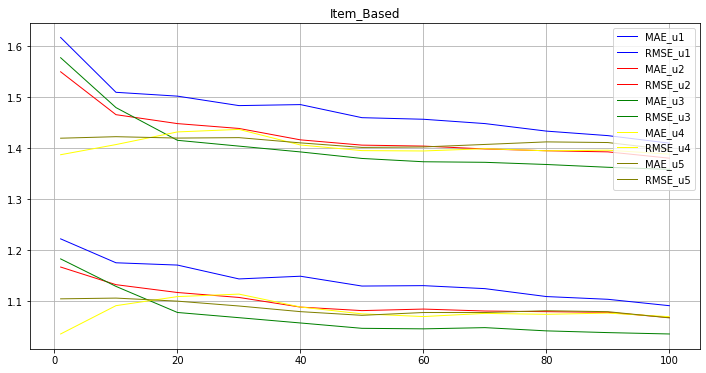

In [139]:
plt.figure(figsize=(12,6)) 
colors_ =['blue', 'red', 'green', 'yellow', 'olive']
for i in range(5): 
   
   plt.plot(n, MAE_result[i], marker='', color=colors_[i], linewidth=1, label = "MAE_u"+str(i+1) )
   plt.plot(n, RMSE_result[i] ,marker='', color=colors_[i], linewidth=1, label = "RMSE_u"+str(i+1))
   plt.title('Item based for each dataset')   
   plt.legend()
   plt.grid()
   #plt.show()


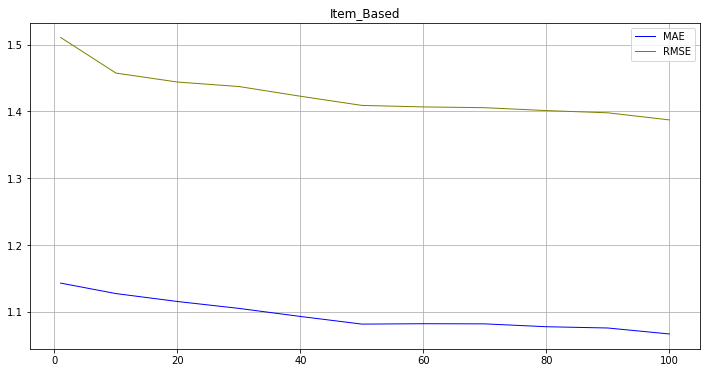

In [141]:
plt.figure(figsize=(12,6)) 
plt.plot(n, MAE_result_mean, marker='', color='blue', linewidth=1, label = "MAE" )
plt.plot(n, RMSE_result_mean ,marker='', color='olive', linewidth=1, label = "RMSE")
plt.title('Item based for all datasetes')
plt.legend()
plt.grid()


User-based collaborative filtering

In [44]:
def cal_MAE_RMSE_User(train, test, id_train, id_test, neighbours_list):
  n = neighbours_list
  name1 = train 
  name2 = test 
  id1 = id_train 
  id2 = id_test
  MAE_user  = np.zeros(len(n))
  RMSE_user = np.zeros(len(n))
  num_RMSE_user = np.zeros(len(n))
  num_MAE_user = np.zeros(len(n))

  for i in range(len(n)):       
     user_match = []
     new_pref_train = {}
     User_Recommendation_dic_train={}
     for j in id1:
       user_match = topMatches(name1,j,n[i])
       user_match = [user[1] for user in user_match] + [j]
       for user in user_match:
         new_pref_train[user] = name1[user]
       User_Recommendation_dic_train[j] = getRecommendations(new_pref_train,j)

     
     # Evaluate
     for k in id2:  # k is id of user
       for key in name2[k].keys():  #key is name of film
        # for key in key_tset.keys():
           for item in User_Recommendation_dic_train[k]:  #item is name of film
             if item[1] == key:
               MAE_user[i] += abs(item[0] - name2[k][key])
               num_MAE_user[i] += 1
               RMSE_user[i] += (item[0] - name2[k][key])**2
               num_RMSE_user[i] += 1
               
  MAE_user = MAE_user / num_MAE_user
  RMSE_user  = RMSE_user / num_RMSE_user
  RMSE_user = np.sqrt(RMSE_user)
  return MAE_user, RMSE_user



In [169]:
MAE_result_user = []
RMSE_result_user = []
i = 0
n = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for name1, name2, id1, id2 in zip(list_train,list_test, list_train_id, list_test_id) :
   MAE, RMSE = cal_MAE_RMSE_User(name1, name2, id1, id2, n)
   MAE_result_user.append(MAE)
   RMSE_result_user.append(RMSE)


In [170]:
MAE_result_user= np.array(MAE_result_user)
MAE_result_user_mean = MAE_result_user.mean(axis=0)

RMSE_result_user= np.array(RMSE_result_user)
RMSE_result_user_mean = RMSE_result_user.mean(axis=0)

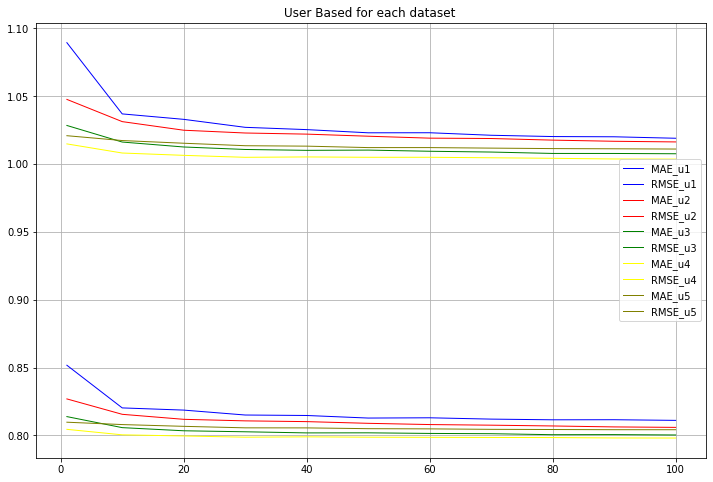

In [175]:
plt.figure(figsize=(12,8)) 
colors_ =['blue', 'red', 'green', 'yellow', 'olive']
for i in range(5):      
   plt.plot(n, MAE_result_user[i], marker='', color=colors_[i], linewidth=1, label = "MAE_u"+str(i+1) )
   plt.plot(n, RMSE_result_user[i] ,marker='', color=colors_[i], linewidth=1, label = "RMSE_u"+str(i+1))
   plt.title('User Based for each dataset ')
   plt.legend()
   plt.grid()


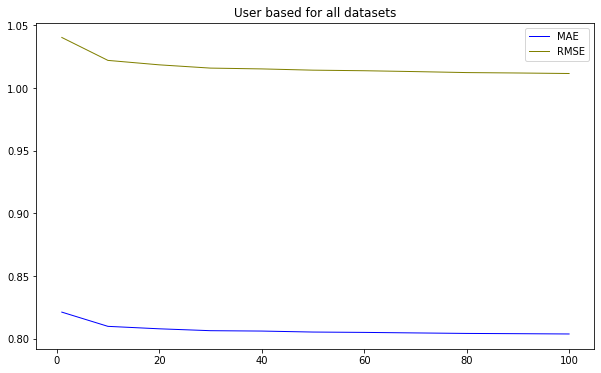

In [176]:
plt.figure(figsize=(10,6))
plt.plot(n, MAE_result_user_mean, marker='', color='blue', linewidth=1, label = "MAE" )
plt.plot(n, RMSE_result_user_mean  ,marker='', color='olive', linewidth=1, label = "RMSE")
plt.title('User based for all datasets')
plt.legend()

##Task 3 + 4

I just tried to implement this formula because MAE < 1 so I do not need to use it :)

$$r_{u,i} = \bar{r_u} +  k\sum\limits_{u^\prime \in U} sim(u,u^\prime)(r_{u^\prime, i}-\bar{r_{u^\prime}} ) \mbox{, где } k =1/\sum_{u^\prime \in U}|\operatorname{sim}(u,u^\prime)|.$$

In [177]:
def getRecommendations_2_user(prefs, person, similarity = sim_pearson):
    
   
    sum_rankings = {}
    simSums = {}
    avg_rank = {}

    for other in prefs: 
      n = 0
      for item in prefs[other]:
             # print(prefs[person],item)
              avg_rank.setdefault(other, 0)
              avg_rank[other] += prefs[other][item]
              n += 1
      avg_rank[other] = avg_rank[other] / n
    #2.calculate similarity and k
    for other in prefs:
     # don't compare me to myself
        if other == person: 
          continue
        sim = similarity(prefs, person, other)

        for item in prefs[other]:
        # only score movies I haven't seen yet
            if item not in prefs[person] or prefs[person][item] == 0:
                # Similarity * Score
                sum_rankings.setdefault(item, 0)
                sum_rankings[item] += (prefs[other][item] - avg_rank[other]) * sim
                # Sum of similarities
                simSums.setdefault(item, 0)
                simSums[item] += np.abs(sim)  # calculate k
    
    # Create the normalized list

    # print(totals)
    # print(simSums) 
    rankings = [((rank / simSums[item]) + avg_rank[person] , item) for item, rank in sum_rankings.items()] # ADD r_u, DONT FORGET

    # Return the sorted list
    rankings.sort()
    rankings.reverse()
    return rankings

In [180]:
def user_based_reco1(train, test, id_train, id_test, neighbours):
   n = neighbours
   name1 = train 
   name2 = test 
   id1 = id_train 
   id2 = id_test
   MAE = np.zeros(len(n))
   RMSE = np.zeros(len(n))
   num = np.zeros(len(n))
   #for name1, name2, id1, id2 in zip(list_train,list_test, list_train_id, list_test_id) :
   for i in range(len(n)):    
     
     user_match = []
     new_pref_train = {}
     User_Recommendation_dic_train={}
     for j in id1:
       user_match = topMatches(name1,j,n[i])
       user_match = [user[1] for user in user_match] + [j]
       for user in user_match:
         new_pref_train[user] = name1[user]
         #print(new_pref_train[user])
       User_Recommendation_dic_train[j] = getRecommendations_2_user(new_pref_train,j)

     
     # Evaluate
     for k in id2:  # k is id of user
       for key in name2[k].keys():  #key is name of film
        # for key in key_tset.keys():
           for item in User_Recommendation_dic_train[k]:  #item is name of film
             if item[1] == key:
               MAE[i] += abs(item[0] - name2[k][key])               
               RMSE[i] += (item[0] - name2[k][key])**2
               num[i] += 1

   MAE = MAE / num
   RMSE  = RMSE / num

   return MAE, RMSE


In [ ]:
n = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
MAE_result_user = []
RMSE_result_user = []
i = 0
for name1, name2, id1, id2 in zip(list_train,list_test, list_train_id, list_test_id) :
   MAE, RMSE =user_based_reco1(name1, name2, id1, id2, n)
   MAE_result_user.append(MAE)
   RMSE_result_user.append(RMSE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
MAE_result_user= np.array(MAE_result_user)
MAE_result_user_mean = MAE_result_user.mean(axis=0)

RMSE_result_user= np.array(RMSE_result_user)
RMSE_result_user_mean = RMSE_result_user.mean(axis=0)

In [ ]:
plt.figure(figsize=(12,6)) 
colors_ =['blue', 'red', 'green', 'yellow', 'olive']
for i in range(5):
   plt.figure(figsize=(12,6))    
   plt.plot(n, MAE_result_user[i], marker='', color=colors_[i], linewidth=1, label = "MAE_u"+str(i+1) )
   plt.plot(n, RMSE_result_user[i] ,marker='', color=colors_[i], linewidth=1, label = "RMSE_u"+str(i+1))
   plt.title('User Based for each dataset ')
   plt.legend()


In [ ]:
plt.figure(figsize=(10,6))
plt.plot(n, MAE_result_user_mean, marker='', color='blue', linewidth=1, label = "MAE" )
plt.plot(n, RMSE_result_user_mean  ,marker='', color='olive', linewidth=1, label = "RMSE")
plt.title('User based for all datasets')
plt.legend()

##Task 5

 Item based

In [45]:
n = [1, 3, 5, 10, 15, 20, 30, 40, 50, 100]
MAE_result_item = []
RMSE_result_item = []

for name1, name2, id1, id2 in zip(list_train,list_test, list_train_id, list_test_id) :
   MAE, RMSE = cal_MAE_RMSE_Item(name1, name2, id1, id2, n)
   MAE_result_item.append(MAE)
   RMSE_result_item.append(RMSE)


In [56]:
MAE_result_item = np.array(MAE_result_item)
MAE_result_item_mean = MAE_result_item.mean(axis=0)

RMSE_result_item = np.array(RMSE_result_item)
RMSE_result_item_mean = RMSE_result_item.mean(axis=0)

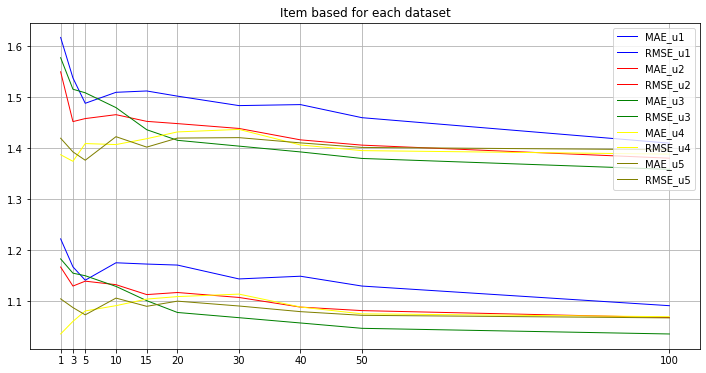

In [107]:
plt.figure(figsize=(12,6)) 
colors_ =['blue', 'red', 'green', 'yellow', 'olive']
for i in range(5): 
   
   plt.plot(n, MAE_result_item[i], marker='', color=colors_[i], linewidth=1, label = "MAE_u"+str(i+1) )
   plt.plot(n, RMSE_result_item[i] ,marker='', color=colors_[i], linewidth=1, label = "RMSE_u"+str(i+1))
   plt.title('Item based for each dataset')   
   plt.legend()
   plt.xticks(n)
   plt.grid()
   #plt.show()

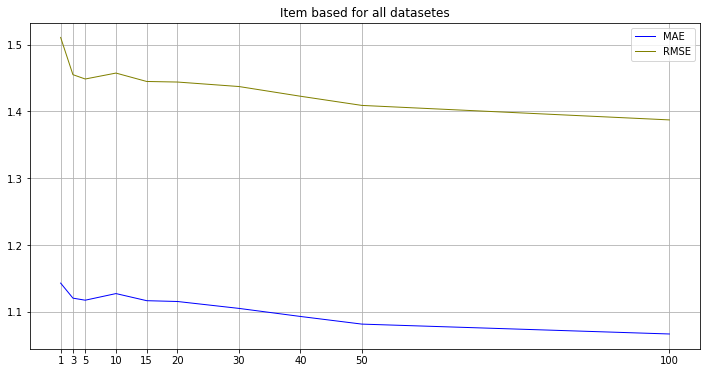

In [60]:
plt.figure(figsize=(12,6)) 
plt.plot(n, MAE_result_item_mean, marker='', color='blue', linewidth=1, label = "MAE" )
plt.plot(n, RMSE_result_item_mean ,marker='', color='olive', linewidth=1, label = "RMSE")
plt.title('Item based for all datasetes')
plt.legend()
plt.xticks(n)
plt.grid()

user based

In [55]:
MAE_result_user = []
RMSE_result_user = []
i = 0
n = [1, 3, 5, 10, 15, 20, 30, 40, 50, 100]
for name1, name2, id1, id2 in zip(list_train,list_test, list_train_id, list_test_id) :
   MAE, RMSE = cal_MAE_RMSE_User( name1, name2, id1, id2, n)
   #print(MAE)
   MAE_result_user.append(MAE)
   RMSE_result_user.append(RMSE)

In [57]:
MAE_result_user= np.array(MAE_result_user)
MAE_result_user_mean = MAE_result_user.mean(axis=0)

RMSE_result_user= np.array(RMSE_result_user)
RMSE_result_user_mean = RMSE_result_user.mean(axis=0)

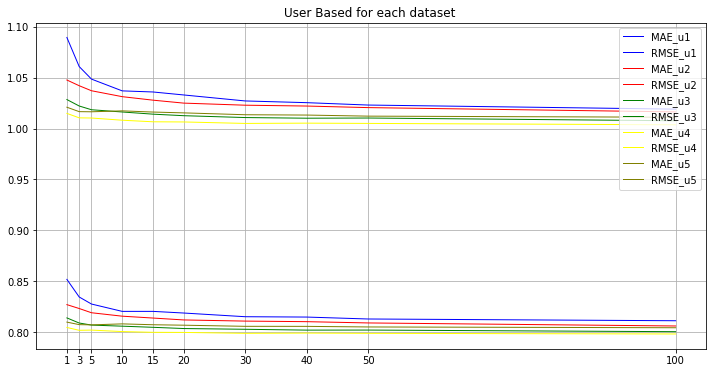

In [59]:
plt.figure(figsize=(12,6))
colors_ =['blue', 'red', 'green', 'yellow', 'olive']
for i in range(5):
       
   plt.plot(n, MAE_result_user[i], marker='', color=colors_[i], linewidth=1, label = "MAE_u"+str(i+1) )
   plt.plot(n, RMSE_result_user[i] ,marker='', color=colors_[i], linewidth=1, label = "RMSE_u"+str(i+1))
   plt.xticks(n)
   plt.title('User Based for each dataset ')
   plt.legend()
   plt.grid()

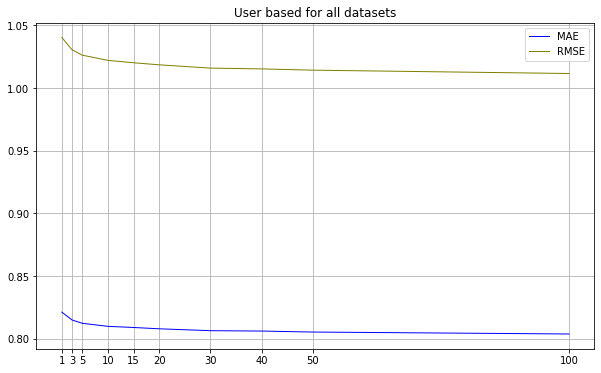

In [109]:
plt.figure(figsize=(10,6))
plt.plot(n, MAE_result_user_mean, marker='', color='blue', linewidth=1, label = "MAE" )
plt.plot(n, RMSE_result_user_mean  ,marker='', color='olive', linewidth=1, label = "RMSE")
plt.title('User based for all datasets')
plt.legend()
plt.xticks(n)
plt.grid()


##Task 6

To achieve these results, I used the one-time user-based approach item-based approach to produce recommendations for the entire dataset. After getting recommendations for each user, I picked the highest rated movies out of over 4 rated recommendations.

In [79]:
def recommendation_film_Item_based(train, id_train ,neighbours):
     #n = neighbours
     name1 = train 
     
     id1 = id_train 
      
     popular_moves = {}
  
  #for i in range(len(n)):    
     itemsim = calculateSimilarItems(name1, neighbours)
     Item_Recommendation_dic_train={}
     for j in id1:
       Item_Recommendation_dic_train[j] = getRecommendedItems(name1, itemsim,j)
       for score, item in Item_Recommendation_dic_train[j]:
         if score >= 4.0:
           popular_moves.setdefault(item, 0)
           popular_moves[item] += 1


     return popular_moves




In [93]:
popular_moves_item_based = recommendation_film_Item_based(prefs, user_id_all, 50)

In [94]:
popular_moves_item_based

{'Winter Guest, The (1997)': 107,
 'Whole Wide World, The (1996)': 231,
 "Some Mother's Son (1996)": 436,
 'Portrait of a Lady, The (1996)': 35,
 'Nobody Loves Me (Keiner liebt mich) (1994)': 214,
 'Mighty, The (1998)': 229,
 'Men of Means (1998)': 96,
 'Manny & Lo (1996)': 180,
 'Mamma Roma (1962)': 381,
 'Major Payne (1994)': 101,
 'MURDER and murder (1996)': 98,
 'Love and Death on Long Island (1997)': 177,
 'Life with Mikey (1993)': 112,
 'Lassie (1994)': 152,
 'Kiss Me, Guido (1997)': 89,
 'Judgment Night (1993)': 80,
 'Jack and Sarah (1995)': 145,
 'Harlem (1993)': 109,
 "Gridlock'd (1997)": 102,
 'Good Man in Africa, A (1994)': 207,
 "Gone Fishin' (1997)": 54,
 'Friday (1995)': 164,
 'Flower of My Secret, The (Flor de mi secreto, La) (1995)': 222,
 'Fausto (1993)': 101,
 'Far From Home: The Adventures of Yellow Dog (1995)': 218,
 'Fall (1997)': 155,
 'Faithful (1996)': 200,
 "Ed's Next Move (1996)": 205,
 'Drunks (1995)': 144,
 'Denise Calls Up (1995)': 170,
 'Death in Brunswick

In [95]:
item_movies_high_rec = sorted(popular_moves_item_based.items(), key=lambda x: x[1], reverse=True)
item_movies_high_rec = {movie:rate for movie, rate in item_movies_high_rec}

In [96]:
item_movies_high_rec

{'Brothers in Trouble (1995)': 498,
 'Butcher Boy, The (1998)': 492,
 'Damsel in Distress, A (1937)': 487,
 'Spanish Prisoner, The (1997)': 486,
 'Marlene Dietrich: Shadow and Light (1996) ': 460,
 'Lady of Burlesque (1943)': 448,
 "Some Mother's Son (1996)": 436,
 'Bitter Sugar (Azucar Amargo) (1996)': 424,
 'They Made Me a Criminal (1939)': 415,
 'Saint of Fort Washington, The (1993)': 399,
 'Death in Brunswick (1991)': 397,
 'Crossfire (1947)': 397,
 'Great Day in Harlem, A (1994)': 382,
 'Mamma Roma (1962)': 381,
 "Someone Else's America (1995)": 375,
 'Anna (1996)': 374,
 'Object of My Affection, The (1998)': 374,
 'Captives (1994)': 353,
 'Prefontaine (1997)': 347,
 'He Walked by Night (1948)': 337,
 'Late Bloomers (1996)': 335,
 'Witness (1985)': 325,
 'Pather Panchali (1955)': 324,
 'Aiqing wansui (1994)': 318,
 'Last Klezmer: Leopold Kozlowski, His Life and Music, The (1995)': 316,
 'Promesse, La (1996)': 316,
 "I Can't Sleep (J'ai pas sommeil) (1994)": 313,
 'A Chef in Love (

In [97]:
def recommendation_film_User_based(train,  id_train,  neighbours):
     n = neighbours
     name1 = train 
     
     id1 = id_train 
      
     popular_moves = {}
  
    #for i in range(len(n)):           
     user_match = []
     new_pref_train = {}
     User_Recommendation_dic_train={}
     for j in id1:
       user_match = topMatches(name1,j,neighbours)
       user_match = [user[1] for user in user_match] + [j]
       for user in user_match:
         new_pref_train[user] = name1[user]
       User_Recommendation_dic_train[j] = getRecommendations(new_pref_train,j)
       for score, item in User_Recommendation_dic_train[j]:
         if score >= 4.0:
           popular_moves.setdefault(item, 0)
           popular_moves[item] += 1


     return popular_moves


In [99]:
popular_moves_user_based = recommendation_film_User_based(prefs, user_id_all, 50)

In [101]:
popular_moves_user_based 

{'Wings of Desire (1987)': 543,
 'Wallace & Gromit: The Best of Aardman Animation (1996)': 874,
 'Until the End of the World (Bis ans Ende der Welt) (1991)': 18,
 'Top Gun (1986)': 3,
 'Third Man, The (1949)': 852,
 'Strange Days (1995)': 2,
 'Stalker (1979)': 187,
 'Speed (1994)': 10,
 'Some Folks Call It a Sling Blade (1993)': 827,
 "Singin' in the Rain (1952)": 435,
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)': 128,
 'Secret of Roan Inish, The (1994)': 215,
 'Rob Roy (1995)': 12,
 'Raise the Red Lantern (1991)': 780,
 'Piano, The (1993)': 5,
 'Othello (1995)': 27,
 'Oscar & Lucinda (1997)': 38,
 'Nénette et Boni (1996)': 255,
 'Nikita (La Femme Nikita) (1990)': 525,
 'Maltese Falcon, The (1941)': 789,
 'Ma vie en rose (My Life in Pink) (1997)': 69,
 'Local Hero (1983)': 416,
 'Little Women (1994)': 19,
 'Laura (1944)': 776,
 'Kaspar Hauser (1993)': 775,
 'House of Yes, The (1997)': 25,
 'Hoop Dreams (1994)': 720,
 'Homeward Bound II: Lost in San Francisco (1996)': 4,
 'Ho

In [104]:
user_movies_high_rec = sorted(popular_moves_user_based .items(), key=lambda x: x[1], reverse=True)
user_movies_high_rec = {movie:rate for movie, rate in user_movies_high_rec}

In [105]:
user_movies_high_rec

{'Pather Panchali (1955)': 908,
 'Crossfire (1947)': 893,
 'Innocents, The (1961)': 880,
 'Wallace & Gromit: The Best of Aardman Animation (1996)': 874,
 'Cérémonie, La (1995)': 853,
 'Third Man, The (1949)': 852,
 'Sunset Blvd. (1950)': 840,
 'Fresh (1994)': 834,
 'Close Shave, A (1995)': 830,
 'Gate of Heavenly Peace, The (1995)': 830,
 'Shall We Dance? (1996)': 828,
 'Some Folks Call It a Sling Blade (1993)': 827,
 'Wrong Trousers, The (1993)': 822,
 'Maya Lin: A Strong Clear Vision (1994)': 822,
 'Prefontaine (1997)': 821,
 '12 Angry Men (1957)': 817,
 'Stonewall (1995)': 806,
 'Manchurian Candidate, The (1962)': 804,
 'Paths of Glory (1957)': 791,
 'Maltese Falcon, The (1941)': 789,
 'Saint of Fort Washington, The (1993)': 788,
 'Cinema Paradiso (1988)': 786,
 'As Good As It Gets (1997)': 785,
 'Manon of the Spring (Manon des sources) (1986)': 784,
 'Sling Blade (1996)': 781,
 'Raise the Red Lantern (1991)': 780,
 'African Queen, The (1951)': 778,
 'Affair to Remember, An (1957)':

##Task 7

Small neighborhood sizes cause considerable increased error.
The plots above show that the “number of neighbors ”  parameter affects the error of the algorithm in a reasonably consistent manner and small number from neighbors caused increasing Mean Absolute Error, then the error became stabel around 20 in user_based approach and around 50 in item_user approach..

in this article https://link.springer.com/article/10.1023%2FA%3A1020443909834 they discussed two modifications to the ratings combination algorithm: rating normalization
and weighting neighbor contributions.

For Weighting neighbor contributions
They computed a similarity measure to locate the closest neighbors, it makes sense to use that similarity measure to weight the contribution of each neighbor based on how close they are to the active user.